## **Showcase 3: Cell conductances to global cerebral dynamics; a model summarizing scales of spontaneous and evoked activity in asynchronous and synchronous brain states.**

#### **Part 1:** Spontaneous activity, asynchronous state

###### *This code has been prepared for EBRAINS by Lionel Kusch, Bahar Hazal Yalçınkaya, Trang-Anh Nghiem, and Jennifer Goldman*
###### *Supervised by Viktor Jirsa and Alain Destexhe*

##### To generate and analyze simulated brain activity using the TVB-AdEX, first Import TVB from EBRAINS:

In [140]:
%%capture --no-display
!pip install --upgrade tvb-library
!pip install --upgrade tvb-data

##### In this simulation, we use the default TVB subject, based on a parcellation of 76 regions. 
##### Each region is modeled as one mean-field. 
##### The mean-fields are connected by excitatory synapses with delays informed by diffusion MR imaging.

##### Next, import the AdEX mean-field model and parameters, as well as libraries used for analyses.

In [141]:
%%capture
from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
parameters = Parameter()
import tvb_model_reference.src.tools_simulation as tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import copy
from scipy import signal
import random

##### Next, chose the length of your simulation (in milliseconds).
##### Keep in mind that you will remove the transient at the begining, which can by up to 3s.
##### We therefore suggest to simulate at least 5000 ms. 

In [142]:
run_sim = 10000.0

##### Chose whether you will produce synchronous or asynchronous dynamics.


In [143]:
state = "asynchronous"

if state == "synchronous":
    parameters.parameter_simulation['path_result'] = './result/DEMO_synchronous_berlin/'
    parameters.parameter_model['b_e'] = 60.0 
    gif_name = state+".gif"
elif state == "asynchronous":
    parameters.parameter_simulation['path_result'] = './result/DEMO_asynchronous_berlin'
    parameters.parameter_model['b_e'] = 0.0 
    gif_name = state+".gif"
else:
    raise NameError("The state can only be synchronous or asynchronous.")


0.0


##### You can also define a stimulus here if you want to study evoked dynamics. 
##### To know the regions indices, you can look at the Jupyter notebook for the PCI analysis, where all are defined. 
##### In this simulation, the stimulus weight is set is set to 0, with **weight[18] = 0**, meaning we observe spontaneous dynamics. If you set the weight to a nonzero value, you will make a stimulus. 

In [144]:
nnodes = 68
weight = list(np.zeros(nnodes))
weight[18] = 0 #5e-4 # [region] and stimulation strength of the region 

parameters.parameter_stimulus['onset']= 500.0 #onset time of the stimulus [ms]
parameters.parameter_stimulus["tau"]= 20 # stimulus duration [ms]
parameters.parameter_stimulus["T"]= 1e9 # interstimulus interval [ms]
parameters.parameter_stimulus["weights"]= weight
parameters.parameter_stimulus["variables"]=[0] #variable to kick; here excitatory firing rate
#0 excitatory, 1 inhibitory, 2 std excitatory, 3 covariation of ex and in, 4 std inhibitory, 5 adaptation excitatory, 6 adaptation inhibitory


stim_time = parameters.parameter_stimulus['onset']
stim_steps = stim_time*10 #number of steps until stimulus 

Here, you can examine the fixed points of the model, where the nullclines cross the bisector. The code is somewhat slow (few minutes), so be patient. 

In [145]:
# tools.print_bistability(parameters.parameter_model)
# plt.show()

Define the coupling and integration details.

In [146]:
simulator = tools.init(parameters.parameter_simulation,
                              parameters.parameter_model,
                              parameters.parameter_connection_between_region,
                              parameters.parameter_coupling,
                              parameters.parameter_integrator,
                              parameters.parameter_monitor,
                              parameter_stimulation=parameters.parameter_stimulus)

##### The following cell runs the simulation. If you change any parameters, you should change the path defined above, and uncomment the lines below to run a new simulation. Otherwise if you leave these lines commented, the analyses will run based on simulations already done for you.
##### The simulation takes roughly 1 min to run each 1 sec of simulation time. 

In [147]:
 tools.run_simulation(simulator,
                            run_sim,
                            parameters.parameter_simulation,
                            parameters.parameter_monitor)

simulation time :1000.0


/Users/kevinancourt/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
simulation time :6000.0
simulation time :7000.0
simulation time :8000.0
simulation time :9000.0
simulation time :10000.0


In [148]:
# cut_transient 
cut_transient = 2000 #time to discard after initialization
end = run_sim

In [149]:
result = tools.get_result(parameters.parameter_simulation['path_result'],cut_transient+0.1,end)
#each step is 0.1ms
result[0][1].shape

(80000, 8, 68)

In [150]:
times = result[0][0]
rateE = result[0][1][:,0,:]
stdE = result[0][1][:,2,:]
rateI = result[0][1][:,1,:]
stdI = result[0][1][:,4,:]
corrEI = result[0][1][:,3,:]
adaptationE = result[0][1][:,5,:]

##These are the state variables of the model
#0 excitatory,
#1 inhibitory
#2 std excitatory, 
#3 covariation of ex and in, 
#4 std inhibitory, 
#5 adaptation excitatory, 
#6 adaptation inhibitory
#7 noise 

In [151]:
Esig = np.transpose(rateE)*1e3 #KHz to Hz
Isig = np.transpose(rateI)*1e3
AdpE = np.transpose(adaptationE)
time_s = times*1e-3 #from ms to sec

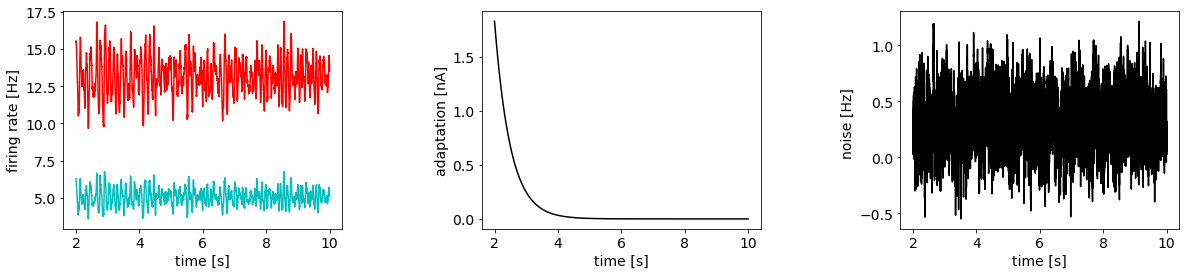

In [152]:
#Plot the excitatory and inhibitory signals, excitatory neuron adaptation, and noise input 
# to the stimulated node
plt.figure(figsize=(20,4))
plt.rcParams.update({'font.size': 14})
ax0 = plt.subplot(131)
ax0.plot(result[0][0]*1e-3,result[0][1][:,0,0]*1e3, 'c')
ax0.plot(result[0][0]*1e-3,result[0][1][:,1,0]*1e3, 'r')
ax0.set_xlabel('time [s]')
ax0.set_ylabel('firing rate [Hz]')
ax1 = plt.subplot(132)
ax1.plot(result[0][0]*1e-3,result[0][1][:,5,0], 'k')
ax1.set_xlabel('time [s]')
ax1.set_ylabel('adaptation [nA]')
ax2 = plt.subplot(133)
ax2.plot(result[0][0]*1e-3,(result[0][1][:,7,0]*parameters.parameter_model['weight_noise']+parameters.parameter_model['external_input_ex_ex'])*1e3, 'k')
ax2.set_xlabel('time [s]')
ax2.set_ylabel('noise [Hz] ')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('Plot_OneNode_'+state+'.png')
plt.show()

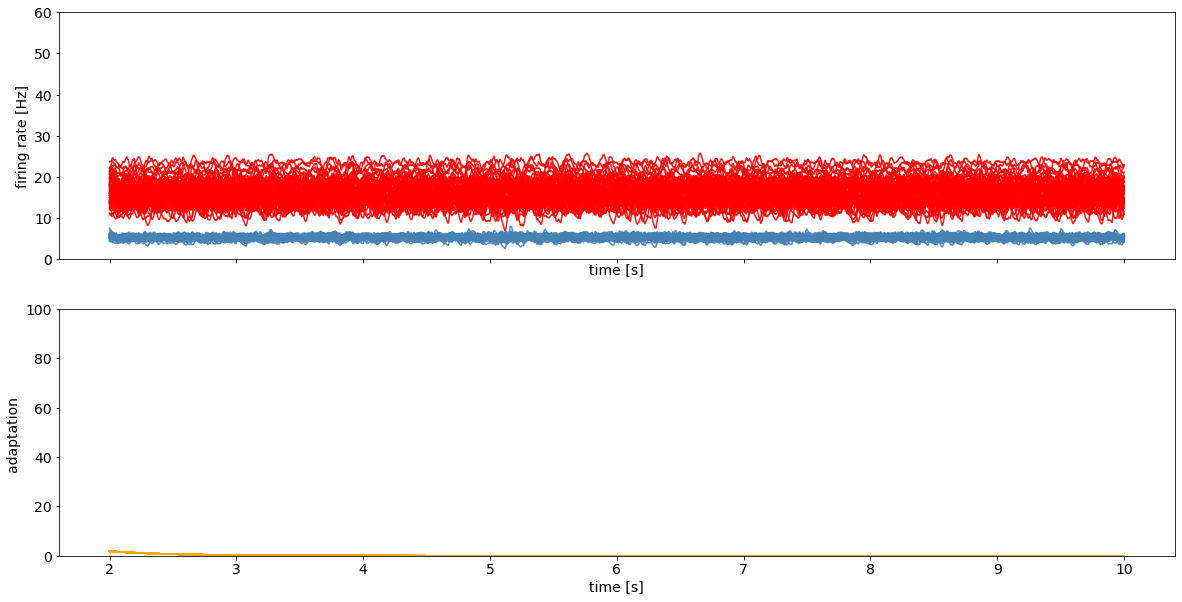

In [153]:
#Plot all the nodes
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)
plt.rcParams.update({'font.size': 14})

for e_node in range(nnodes):
    ax0.plot(time_s,Isig[e_node], '-r', alpha=0.9)
    ax0.plot(time_s,Esig[e_node], color='#4682B4', alpha=0.9) 
ax0.set_xlabel('time [s]')
ax0.set_ylabel('firing rate [Hz]')  
ax0.set_ylim(ymax=60,ymin=0.)

for e_node in range(nnodes):
    ax1.plot(time_s,AdpE[e_node], color='#FFA500', alpha=0.9) 
ax1.set_xlabel('time [s]')
ax1.set_ylabel('adaptation ')  
ax1.set_ylim(ymax=100,ymin=0.)
plt.savefig('Plot_AllNodes_'+state+'.png')
plt.savefig('Plot_AllNodes_'+state+'.pdf')
plt.show()

# #Plot all the nodes
# fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)
# plt.rcParams.update({'font.size': 14})
# for e_node in range(nnodes):
#     ax0.plot(time_s,Esig[e_node], '-c', alpha=0.4)
#     ax0.plot(time_s,Isig[e_node], '-r', alpha=0.2)
# ax0.set_xlabel('time [s]')
# ax0.set_ylabel('firing rate [Hz]')  
# ax0.set_ylim(ymax=50,ymin=0.)

# for e_node in range(nnodes):
#     ax1.plot(time_s,AdpE[e_node],  alpha=0.4)
# ax1.set_xlabel('time [s]')
# ax1.set_ylabel('adaptation ')  
# ax1.set_ylim(ymax=100,ymin=0.)
# plt.savefig('Plot_AllNodes_'+state+'.png')
# plt.savefig('Plot_AllNodes_Asynchronous.pdf')
# plt.show()

##### Now you can analyze signals generated by the model.

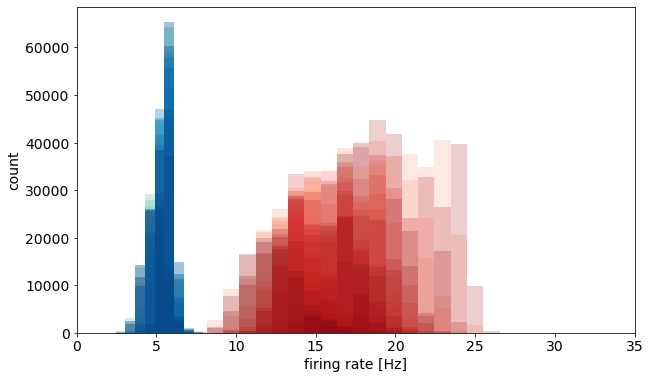

In [154]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
#histogram of I firing rates
color = cm.Reds(np.linspace(0, 1, nnodes))
cmap = plt.get_cmap('Reds')
count = 0
for region in range(nnodes):
    plt.hist(Isig[region], bins = np.linspace(0,50), 
             color = cmap(int(region/nnodes*255)), 
             alpha=0.2, linewidth=1.2)
    
#histogram of E firing rates
color = cm.GnBu(np.linspace(0, 1, nnodes))
count = 0
cmap = plt.get_cmap('GnBu')
for region in range(nnodes):
    plt.hist(Esig[region], bins = np.linspace(0,30), 
             color = cmap(int(region/nnodes*255)),
             alpha=0.4, linewidth=1.2)

plt.xlabel('firing rate [Hz]')
#plt.xlabel(r'$\nu_E [Hz]$')
plt.ylabel('count')  
plt.xlim(0, 35)
#plt.ylim(0, 22000)
plt.savefig('Plot_Histogram_'+state+'.png')
plt.savefig('Plot_Histogram_Asynchronous.pdf')
plt.show()

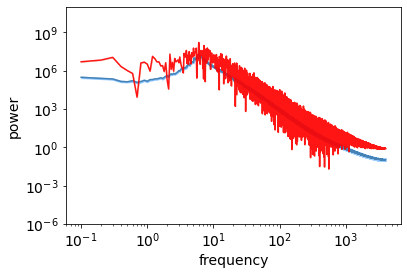

In [155]:
plt.rcParams.update({'font.size': 14})
# plot power spectrum mean over regions and std
f_sampling = 1.*len(time_s)/time_s[-1] # time in seconds, f_sampling in Hz
frq = np.fft.fftfreq(len(times), 1/f_sampling)

# Excitatory
pwr_region_E = []
for e_reg in range(nnodes):
    pwr_region_E.append(np.abs(np.fft.fft(Esig[e_reg]))**2)
    
mean_fft_overregions_E = np.mean(pwr_region_E, axis=0)
mean_E_Hz = mean_fft_overregions_E
plt.loglog(frq[frq > 0], mean_E_Hz[frq > 0], color='SteelBlue')
std_e = np.std(pwr_region_E, axis=0) #std fft between regions
high_e = mean_E_Hz[frq > 0]+std_e[frq > 0]/np.sqrt(nnodes)
low_e =  mean_E_Hz[frq > 0]-std_e[frq > 0]/np.sqrt(nnodes)
plt.fill_between(frq[frq > 0], high_e, low_e, color = 'DodgerBlue', alpha = 0.4)

# Inhibitory
pwr_region_I = []
for i_reg in range(nnodes):
    pwr_region_I.append(np.abs(np.fft.fft(Isig[e_reg]))**2)
    
mean_fft_overregions_I = np.mean(pwr_region_I, axis=0)
mean_I_Hz = mean_fft_overregions_I
plt.loglog(frq[frq > 0], mean_I_Hz[frq > 0], '-r', alpha=0.9)
std_i = np.std(pwr_region_I, axis=0) #std fft between regions
high_i = mean_I_Hz[frq > 0]+std_i[frq > 0]/np.sqrt(nnodes)
low_i =  mean_I_Hz[frq > 0]-std_i[frq > 0]/np.sqrt(nnodes)
plt.fill_between(frq[frq > 0], high_i, low_i, color = 'DarkSalmon', alpha = 0.4)

plt.xlabel('frequency')
#plt.xlabel(r'$\nu_E [Hz]$')
plt.ylabel('power')  
#plt.xlim(0, 20)
plt.ylim(10e-7, 10e10)
#plt.legend(['excitatory', 'inhibitory'])
plt.savefig('Plot_PowerSpectrum_'+state+'.pdf')
plt.show()

# plt.rcParams.update({'font.size': 14})
# # plot power spectrum mean over regions and std
# f_sampling = 1.*len(time_s)/time_s[-1] # time in seconds, f_sampling in Hz
# frq = np.fft.fftfreq(len(times), 1/f_sampling)

# # Excitatory
# pwr_region_E = []
# for e_reg in range(nnodes):
#     pwr_region_E.append(np.abs(np.fft.fft(Esig[e_reg]))**2)
    
# mean_fft_overregions_E = np.mean(pwr_region_E, axis=0)
# mean_E_Hz = mean_fft_overregions_E
# plt.loglog(frq[frq > 0], mean_E_Hz[frq > 0], color='SteelBlue', alpha=0.4)
# std_e = np.std(pwr_region_E, axis=0) #std fft between regions
# high_e = mean_E_Hz[frq > 0]+std_e[frq > 0]/np.sqrt(nnodes)
# low_e =  mean_E_Hz[frq > 0]-std_e[frq > 0]/np.sqrt(nnodes)
# plt.fill_between(frq[frq > 0], high_e, low_e, color = 'DodgerBlue', alpha = 0.4)

# # Inhibitory
# pwr_region_I = []
# for i_reg in range(nnodes):
#     pwr_region_I.append(np.abs(np.fft.fft(Isig[e_reg]))**2)
    
# mean_fft_overregions_I = np.mean(pwr_region_I, axis=0)
# mean_I_Hz = mean_fft_overregions_I
# plt.loglog(frq[frq > 0], mean_I_Hz[frq > 0], '-r', alpha=0.4)
# std_i = np.std(pwr_region_I, axis=0) #std fft between regions
# high_i = mean_I_Hz[frq > 0]+std_i[frq > 0]/np.sqrt(nnodes)
# low_i =  mean_I_Hz[frq > 0]-std_i[frq > 0]/np.sqrt(nnodes)
# plt.fill_between(frq[frq > 0], high_i, low_i, color = 'DarkSalmon', alpha = 0.4)

# plt.xlabel('frequency')
# #plt.xlabel(r'$\nu_E [Hz]$')
# plt.ylabel('power')  
# #plt.xlim(10e-1, 10e2)
# plt.ylim(10e-6, 10e9)
# plt.legend(['excitatory', 'inhibitory'])
# plt.savefig('Plot_PowerSpectrum_'+state+'.pdf')
# plt.show()

Correlation between functional and structural connectome
excitatory  :  40.761110129525626
inihibiotry : 40.9513594549565


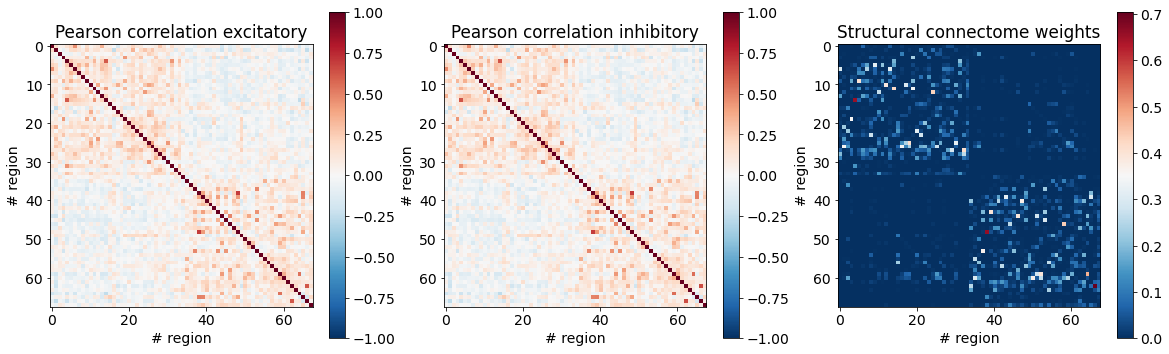

In [156]:
#Functional connectivity (Pearson correlation between mean-field nodes)
#excitatory
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
plt.rcParams.update({'font.size': 14})
pearson_e = np.corrcoef(Esig)

im0 = ax0.imshow(pearson_e, cmap = 'RdBu_r', vmin = -1, vmax = 1, 
           interpolation = 'nearest')
fig.colorbar(im0, ax=ax0)
ax0.set_xlabel('# region')
ax0.set_ylabel('# region') 
ax0.set_title('Pearson correlation excitatory')

#inhibitory
pearson_i = np.corrcoef(Isig)
im1 = ax1.imshow(pearson_i, cmap = 'RdBu_r', vmin = -1, vmax = 1, 
           interpolation = 'nearest')
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('# region')
ax1.set_ylabel('# region') 
ax1.set_title('Pearson correlation inhibitory')

im2 = ax2.imshow(simulator.connectivity.weights, cmap = 'RdBu_r', interpolation = 'nearest')
fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('# region')
ax2.set_ylabel('# region') 
ax2.set_title('Structural connectome weights')
plt.savefig('Plot_FunctionStructureConnectome_'+state+'.pdf')
print("Correlation between functional and structural connectome")
print("excitatory  : ",np.corrcoef(x=pearson_e,y=simulator.connectivity.weights)[0,1]*100)
print("inihibiotry :" ,np.corrcoef(x=pearson_i,y=simulator.connectivity.weights)[0,1]*100)

Ttest_indResult(statistic=-0.6655029030057427, pvalue=0.5057454881809271)


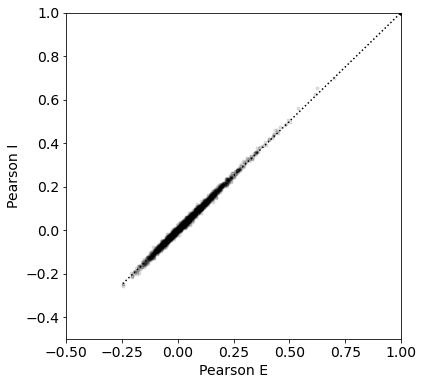

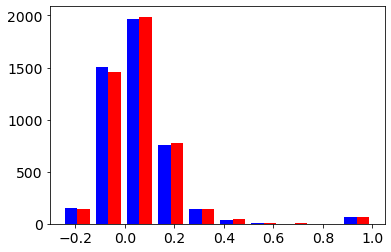

In [157]:
plt.figure(figsize=(6,6))

plt.plot(np.concatenate(pearson_e), np.concatenate(pearson_i), 'k.', alpha=0.05)
plt.plot(np.sort(np.concatenate(pearson_e)),np.sort(np.concatenate(pearson_e)),'k:')
plt.xlim(-0.5,1.0)
plt.ylim(-0.5,1.0)
plt.xlabel('Pearson E')
plt.ylabel('Pearson I')

plt.savefig('Plot_EvsICor_'+state+'.pdf')
plt.savefig('Plot_EvsICor_'+state+'.png')

plt.figure()
plt.hist([np.concatenate(pearson_e), np.concatenate(pearson_i)], color = ['b', 'r'], label = ['E', 'I'])

#stats
from scipy import stats
print(stats.ttest_ind(np.concatenate(pearson_e), np.concatenate(pearson_i)))

Ttest_indResult(statistic=0.0, pvalue=1.0)


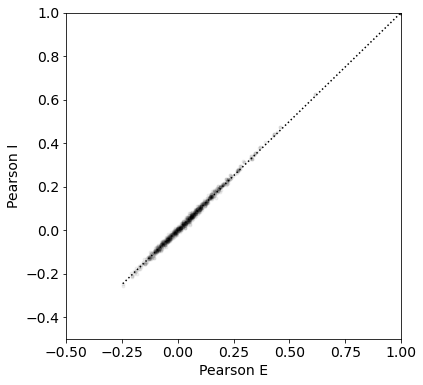

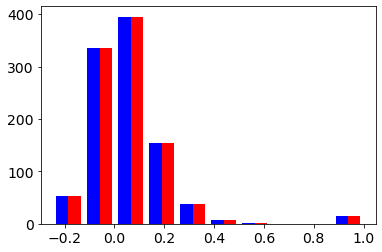

In [159]:
vec_pearson_e=np.concatenate(pearson_e)
vec_pearson_i=np.concatenate(pearson_i)

size_downsample=1000

downsample_pearson_e=[]
downsample_pearson_i=[]
down_id=np.arange(size_downsample)

for i in range (size_downsample):
    downsample_pearson_e= np.append(downsample_pearson_e,vec_pearson_e[down_id[i]])
    downsample_pearson_i= np.append(downsample_pearson_i,vec_pearson_i[down_id[i]])
    
    

plt.figure(figsize=(6,6))

plt.plot(downsample_pearson_e, downsample_pearson_i, 'k.', alpha=0.05)
plt.plot(np.sort(downsample_pearson_e),np.sort(downsample_pearson_e),'k:')
plt.xlim(-0.5,1.0)
plt.ylim(-0.5,1.0)
plt.xlabel('Pearson E')
plt.ylabel('Pearson I')

plt.savefig('Plot_EvsICor_downsample_'+state+'.pdf')
plt.savefig('Plot_EvsICor_downsample_'+state+'.png')

plt.figure()
plt.hist([downsample_pearson_e, downsample_pearson_e], color = ['b', 'r'], label = ['E', 'I'])

#stats
from scipy import stats
print(stats.ttest_ind(downsample_pearson_e, downsample_pearson_e))
    
    


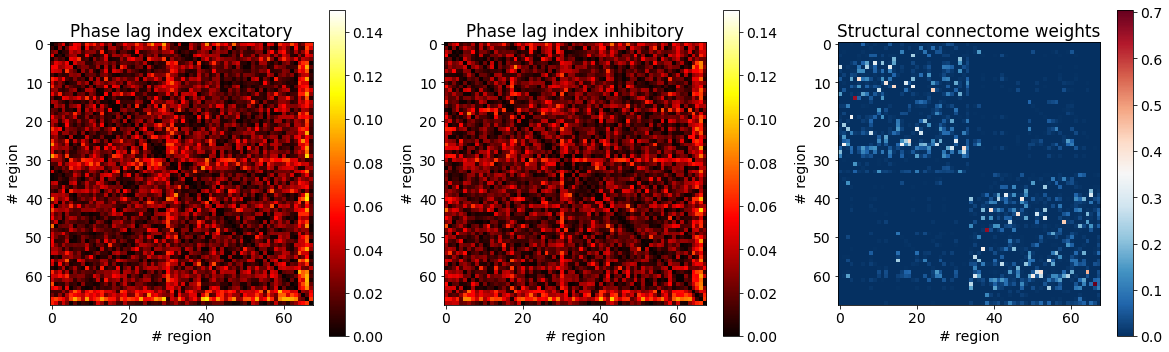

In [160]:
#%% Phase lag index between mean-field nodes
# Taking Hilbert transform, extracting phase and amplitude
# be careful, this is much more meaningful when 
# the signal is dominated by one frequency range, eg slow waves

#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
plt.rcParams.update({'font.size': 14})
#excitatory
hilb_phase_region_e = np.zeros_like(Esig)
PLI_e = np.zeros((nnodes, nnodes))

hilb_amplitude_region_e = np.zeros_like(Esig)
hilb_phase_region_e = np.zeros_like(Esig)

for e_reg in range(nnodes):
    hilb = signal.hilbert(Esig[e_reg])
    hilb_amplitude_region_e[e_reg] = np.abs(hilb)
    hilb_phase_region_e[e_reg] = np.angle(hilb)

for e_reg in range(nnodes):
    for j_reg in range(e_reg, nnodes):
        phase_lags = hilb_phase_region_e[e_reg] \
        - hilb_phase_region_e[j_reg]
        PLI_e[e_reg][j_reg] = np.abs(np.mean(np.sign(phase_lags)))
        PLI_e[j_reg][e_reg] = PLI_e[e_reg][j_reg]

im0 = ax0.imshow(PLI_e, cmap = 'hot', vmin = 0, vmax = 0.15, 
           interpolation = 'nearest')
fig.colorbar(im0, ax=ax0)
ax0.set_xlabel('# region')
ax0.set_ylabel('# region') 
ax0.set_title('Phase lag index excitatory')

#inhibitory
hilb_phase_region_i = np.zeros_like(Isig)
PLI_i = np.zeros((nnodes, nnodes))

hilb_amplitude_region_i = np.zeros_like(Isig)
hilb_phase_region_i = np.zeros_like(Isig)

for i_reg in range(nnodes):
    hilb = signal.hilbert(Isig[i_reg])
    hilb_amplitude_region_i[i_reg] = np.abs(hilb)
    hilb_phase_region_i[i_reg] = np.angle(hilb)

for i_reg in range(nnodes):
    for j_reg in range(i_reg, nnodes):
        phase_lags = hilb_phase_region_i[i_reg] \
        - hilb_phase_region_i[j_reg]
        PLI_i[i_reg][j_reg] = np.abs(np.mean(np.sign(phase_lags)))
        PLI_i[j_reg][i_reg] = PLI_i[i_reg][j_reg]

im1 = ax1.imshow(PLI_i, cmap = 'hot', vmin = 0, vmax = 0.15, 
           interpolation = 'nearest')
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('# region')
ax1.set_ylabel('# region') 
ax1.set_title('Phase lag index inhibitory')
im2 = ax2.imshow(simulator.connectivity.weights, cmap = 'RdBu_r', interpolation = 'nearest')

fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('# region')
ax2.set_ylabel('# region') 
ax2.set_title('Structural connectome weights')

plt.savefig('Plot_PhaseLagIndex_'+state+'.pdf')

Ttest_indResult(statistic=5.124163351272508, pvalue=3.049002518975602e-07)


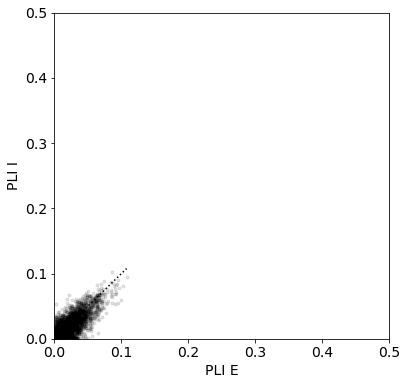

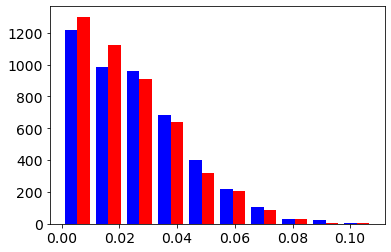

In [161]:
plt.figure(figsize=(6,6))

plt.plot(np.concatenate(PLI_e), np.concatenate(PLI_i), 'k.', alpha=0.05)
plt.plot(np.sort(np.concatenate(PLI_e)),np.sort(np.concatenate(PLI_e)),'k:')
plt.xlim(0.0,0.5)
plt.ylim(0.0,0.5)
plt.xlabel('PLI E')
plt.ylabel('PLI I')

plt.savefig('Plot_EvsIPLI_'+state+'.pdf')
plt.savefig('Plot_EvsIPLI_'+state+'.png')

plt.figure()
plt.hist([np.concatenate(PLI_e), np.concatenate(PLI_i)], color = ['b', 'r'], label = ['E', 'I'])

#stats
from scipy import stats
print(stats.ttest_ind(np.concatenate(PLI_e), np.concatenate(PLI_i)))

Ttest_indResult(statistic=2.198952094794201, pvalue=0.02799556623018044)


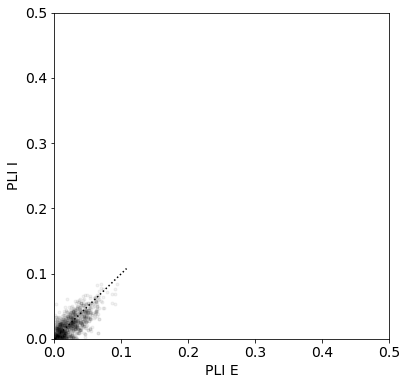

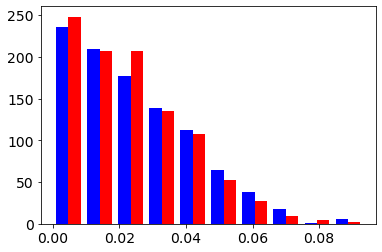

In [162]:
vec_PLI_e=np.concatenate(PLI_e)
vec_PLI_i=np.concatenate(PLI_i)

size_downsample=1000

downsample_PLI_e=[]
downsample_PLI_i=[]

down_id= np.arange(size_downsample)
for i in range (size_downsample):
    downsample_PLI_e= np.append(downsample_PLI_e,vec_PLI_e[down_id[i]])
    downsample_PLI_i= np.append(downsample_PLI_i,vec_PLI_i[down_id[i]])

plt.figure(figsize=(6,6))

plt.plot(downsample_PLI_e, downsample_PLI_i, 'k.', alpha=0.05)
plt.plot(np.sort(np.concatenate(PLI_e)),np.sort(np.concatenate(PLI_e)),'k:')
plt.xlim(0.0,0.5)
plt.ylim(0.0,0.5)
plt.xlabel('PLI E')
plt.ylabel('PLI I')

plt.savefig('Plot_EvsIPLI_downsample_'+state+'.pdf')
plt.savefig('Plot_EvsIPLI_downsample_'+state+'.png')

plt.figure()
plt.hist([downsample_PLI_e, downsample_PLI_i], color = ['b', 'r'], label = ['E', 'I'])

#stats
from scipy import stats
print(stats.ttest_ind(downsample_PLI_e, downsample_PLI_i))    

In [163]:
# import library for ploting surface
from tvb_model_reference.view.plot import multiview
from tvb.simulator.lab import cortex as ct
from tvb.simulator.lab import region_mapping as rm
from tvb.simulator.lab import surfaces as surf

In [164]:
# import data of surface
region_mapping_data = np.loadtxt(parameters.parameter_connection_between_region['path']+'/RegionMapping.txt',dtype=np.int)
surface_cortex = surf.Surface().from_file(parameters.parameter_connection_between_region['path']+'/Surface_Cortex.zip')
hemispheres_right = np.where([False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])[0]
hemispheres_left = np.where(np.logical_not([False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True]))[0]

/Users/kevinancourt/opt/anaconda3/envs/tvb-run/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [165]:
# configure surface data for ploting
tmp = np.copy(surface_cortex.vertices[:,0])
surface_cortex.vertices[:,0] = surface_cortex.vertices[:,1]
surface_cortex.vertices[:,1] = tmp
region_mapping=rm.RegionMapping(array_data=region_mapping_data,connectivity=simulator.connectivity,surface=surface_cortex)
cortex = ct.Cortex().from_file()
cortex.region_mapping_data = region_mapping

In [166]:
# get data for plotting
raw_data = tools.get_result(parameters.parameter_simulation['path_result'], cut_transient, run_sim)[0][1]
the_data = (np.mean(raw_data,0)[0,:])*1e3

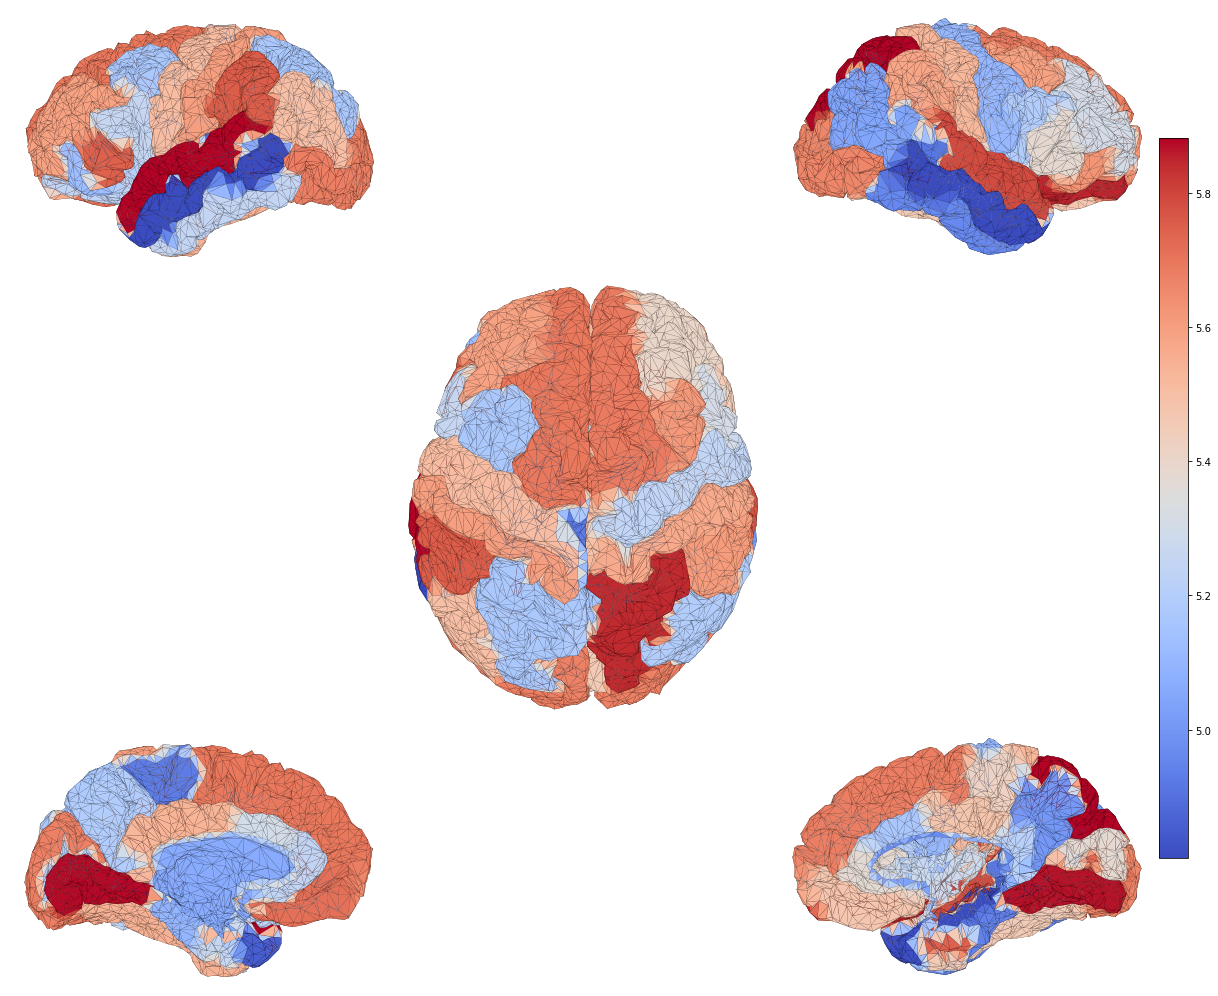

In [167]:
# plot data on the brain
multiview(cortex,hemispheres_left,hemispheres_right,the_data[region_mapping.array_data],plt.figure(figsize=(20, 20)), shaded=False, CB_position=[0.8, 0.25, 0.02, 0.5], CB_orientation='vertical')
plt.savefig('Plot_BrainSpace_'+state+'.png')
plt.show()

In [168]:
# import tools for the animation
from tvb_model_reference.view.plot import animation

In [169]:
# get data to plot on the brain for the animation
Ex = tools.get_result(parameters.parameter_simulation['path_result'], cut_transient, run_sim)[0][1][:,0,:]
data = []
for index,i in enumerate(Ex):
    if  index % 10 == 0:
        data.append(i[cortex.region_mapping])

In [170]:
# make the movie (gif)
for i in range(0,int(len(data)/100)):
##    only uncomment the line below if you would like to make a new movie (requires a lot of time and memory)
#     animation(cortex,hemispheres_left,hemispheres_right,data,i*100,(i+1)*100,parameters.parameter_simulation['path_result']+str(i)+gif_name)
    plt.close('all')

In [171]:
%%HTML
<div>
<h1> ASYNCHROUNOUS simulation </h1>
</div>
<div>
<video width="900" height="900" controls>
<source src='./result/DEMO_asynchronous_berlin/asynch.mp4' type="video/mp4" /> 
</video>       
</div>

In [172]:
%%HTML
<!-- for i in *.gif; do ffmpeg -f gif -i $i -pix_fmt yuv420p $i.mp4;echo $i; echo "file './$i.mp4'" >>list_gif.txt; done;
ffmpeg -f concat -safe 0 -i list_gif.txt -c copy output.mp4
ffmpeg -i output.mp4 -filter:v "setpts=0.25*PTS" output_2.mp4 -->
<div>
<h1> SYNCHROUNOUS simulation </h1>
</div>
<div>
<video width="900" height="900" controls>
<source src='./result/DEMO_synchronous_berlin/synchronous.mp4' type="video/mp4" /> 
</video> 
</div>

In [173]:
##Plot just 50 ms mean in brain space

# get data for plotting
raw_data = tools.get_result(parameters.parameter_simulation['path_result'], cut_transient, cut_transient+200)[0][1]
the_data = (np.mean(raw_data,0)[0,:])*1e3

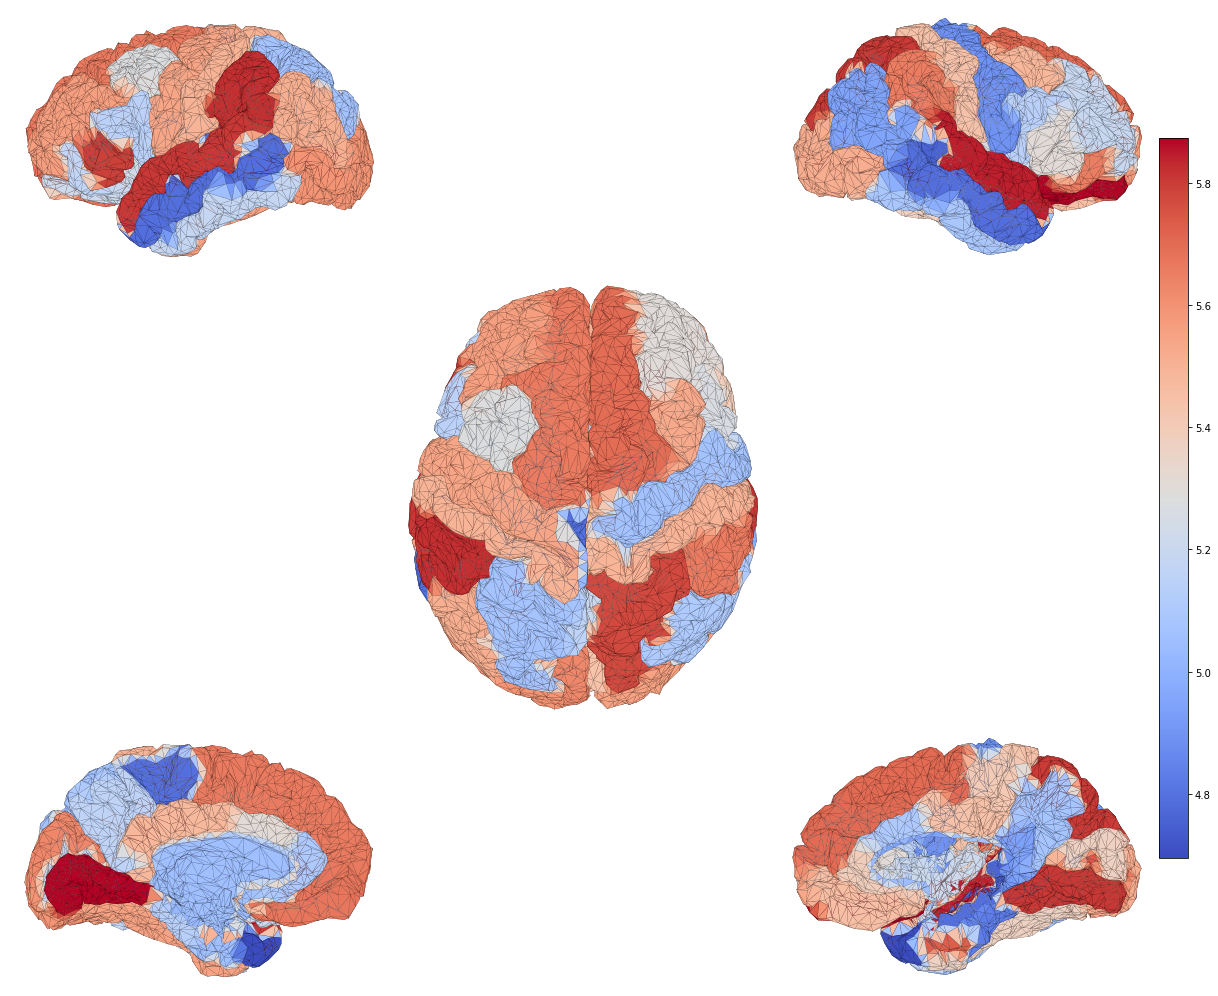

In [174]:
# plot data on the brain
multiview(cortex,hemispheres_left,hemispheres_right,the_data[region_mapping.array_data],plt.figure(figsize=(20, 20)), shaded=False, CB_position=[0.8, 0.25, 0.02, 0.5], CB_orientation='vertical')
plt.savefig('Plot_BrainSpace_200ms_'+state+'.pdf')
plt.savefig('Plot_BrainSpace_200ms_'+state+'.png')
plt.show()